## Work flow
Koden ligger i "EKSAMEN.py", hvor scrapes are defineret som Classes, mens resten er skrevet som funktioner.

In [1]:
# Import Modules - external as well as our pyfile 
import EKSAMEN
from EKSAMEN import *
import importlib
importlib.reload(EKSAMEN)

import requests
import tqdm
import time
import pandas as pd
import json
import os
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, box
import numpy as np
from scipy.spatial import cKDTree
import ast
import matplotlib.pyplot as plt
from pyproj import Transformer
from geopy.distance import geodesic
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load data from csv's

In [2]:
pd.set_option('display.max.columns', 100)
csv1 = "final_real_estate_postings.csv"
df_real_estate = pd.read_csv(csv1, low_memory=False)
csv2 = "final_job_postings.csv"
df_jobs = pd.read_csv(csv2, low_memory=False)

## Extract coordinates and create GeoDataFrames
We start by exploiting that both dataframes have coordinates. The real estate data has to be parsed in order that we can create the GDF for the real estate listings. 

In [3]:
real_estate_gdf = create_gdf_real_estate(df_real_estate)
job_listings_gdf = create_gdf_jobs(df_jobs)

## Creating a Grid 
We move on to "gridding": Our objective is to divide Denmark into grid cells. This reduces the problem from individual points to areas. Instead of O(n * m) where n is the number of houses and m is the number of jobs, this approach is closer to O(n log m) in average cases, which is much more efficient.

In [4]:
grid_cells = create_grid(real_estate_gdf)

## Calculate job density for each grid cell

In [5]:
grid_cells = calculate_job_density(grid_cells, job_listings_gdf)

# Spatial join to assign grid cell attributes to real estate listings
real_estate_with_density = gpd.sjoin(real_estate_gdf, grid_cells, how="left", predicate="within")

## Define job centers (e.g., cells with job density > 95th percentile)
Notes, this next command takes a bit of time to run. 

In [6]:
job_centers = grid_cells[grid_cells['job_density'] > grid_cells['job_density'].quantile(0.95)]

## Calculating Distance to nearest Job Center 

In [7]:
real_estate_with_density['distance_to_job_center'] = nearest_neighbor(real_estate_gdf, job_centers)

## Adding 'Jobs within 5km' 

In [8]:
job_count_5km_series = calculate_job_count_5km(real_estate_gdf, job_listings_gdf)

# Ensure job_count_5km_series is properly indexed and of the correct type
job_count_5km_series = job_count_5km_series.reindex(real_estate_with_density.index, fill_value=0)

# If job_count_5km_series is a DataFrame, convert it to a Series
if isinstance(job_count_5km_series, pd.DataFrame):
    job_count_5km_series = job_count_5km_series.iloc[:, 0]

# Assign the job_count_5km_series to the real_estate_with_density DataFrame
real_estate_with_density['job_count_5km'] = job_count_5km_series

## Preparing dataset for Visual Analysis 

In [9]:
ml_dataset = prepare_ml_dataset(real_estate_with_density)

## Visuals 

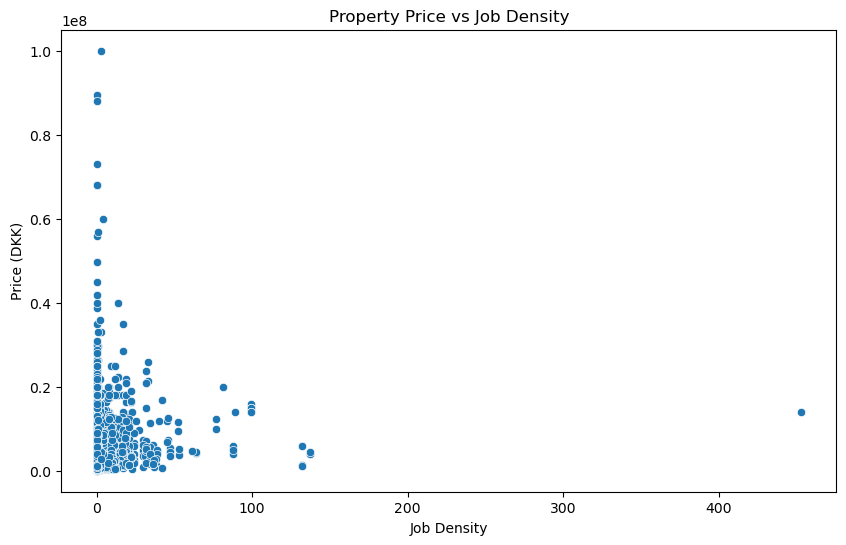

In [10]:
plot_price_vs_job_density(ml_dataset)

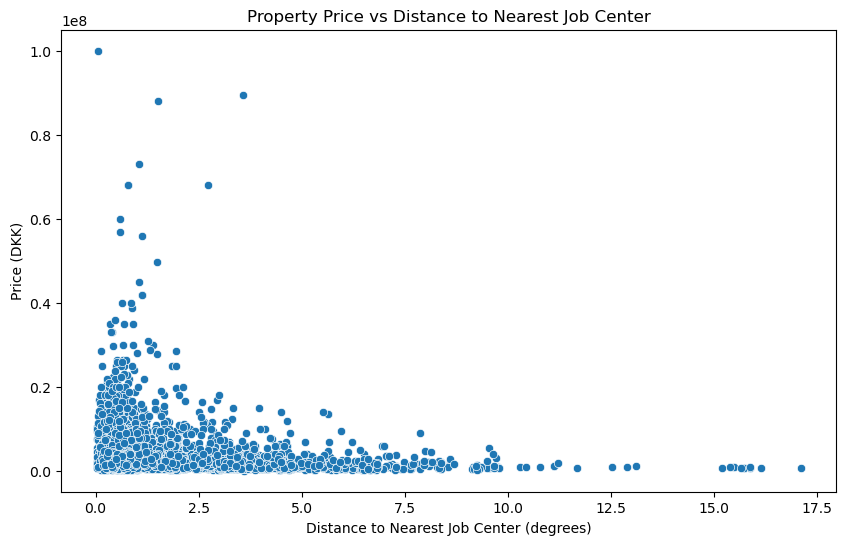

In [11]:
plot_price_vs_distance_to_job_center(ml_dataset)

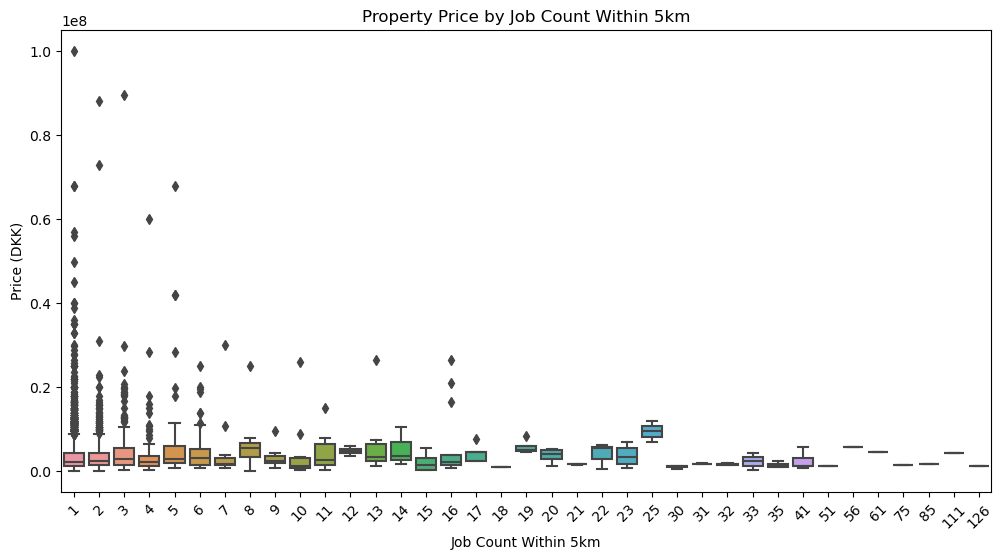

In [12]:
plot_price_by_job_count_5km(ml_dataset)

<Figure size 1200x1000 with 0 Axes>

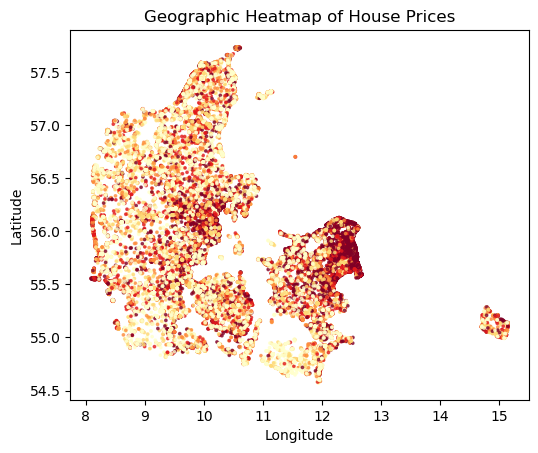

In [13]:
plot_heatmap_house_prices(real_estate_with_density)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1200x1000 with 0 Axes>

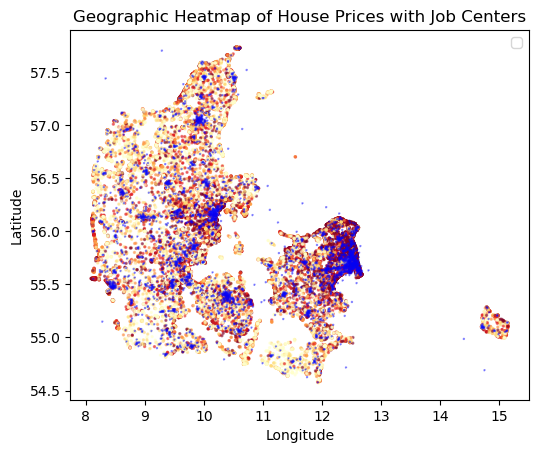

In [14]:
EKSAMEN.plot_heatmap_with_jobs_overlaid(real_estate_with_density, job_centers)

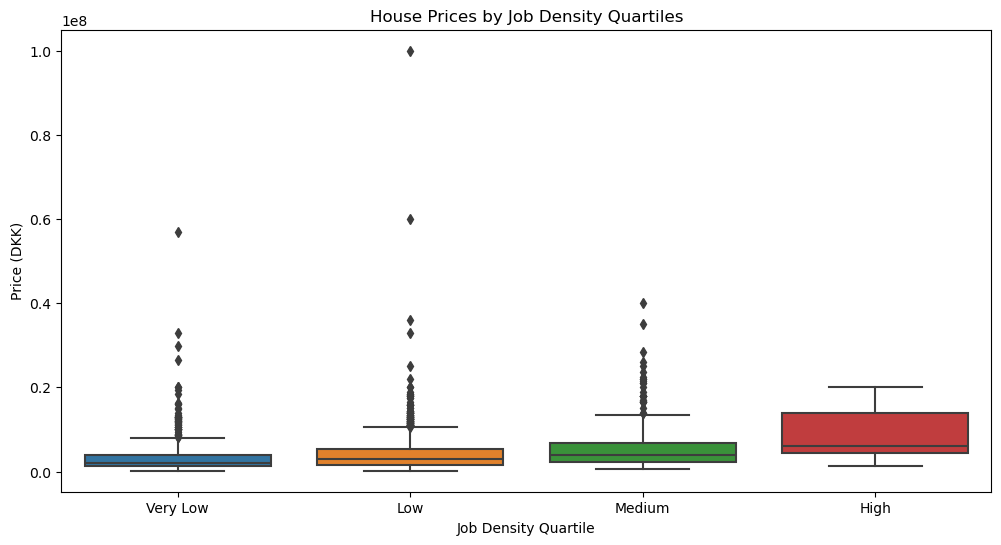

In [15]:
EKSAMEN.plot_house_prices_by_job_density(ml_dataset)

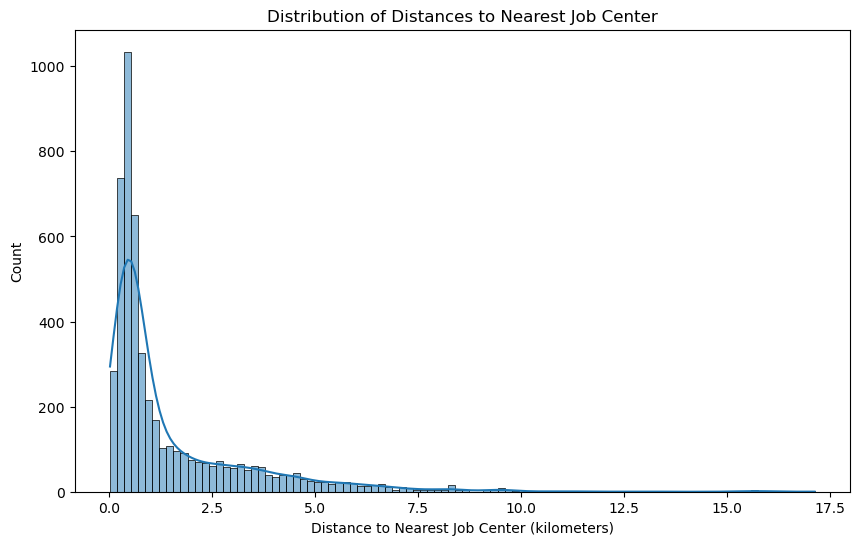

In [16]:
EKSAMEN.dist_distance_nearest_center(ml_dataset)

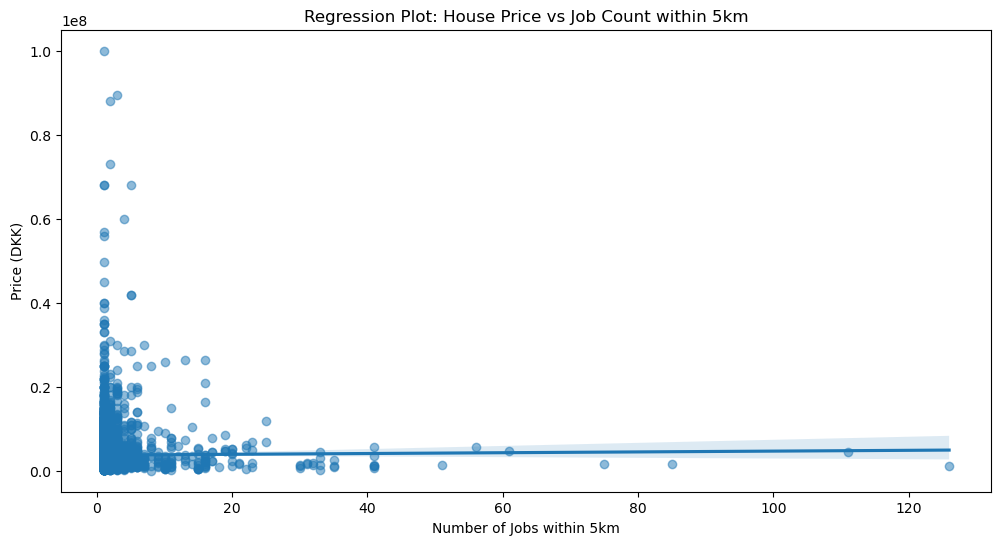

In [17]:
EKSAMEN.regression_plot_houseprices_jobcount(ml_dataset)

## Testing Scrape 

In [18]:
scraper = EKSAMEN.RealEstateScraper(completed_pages_file='completed_pages.json')
scraper.scrape()

Scraping data for: villa
Skipping already downloaded page 1 for villa
Skipping already downloaded page 2 for villa
Skipping already downloaded page 3 for villa
Skipping already downloaded page 4 for villa
Skipping already downloaded page 5 for villa
Skipping already downloaded page 6 for villa
Skipping already downloaded page 7 for villa
Skipping already downloaded page 8 for villa
Skipping already downloaded page 9 for villa
Skipping already downloaded page 10 for villa
Skipping already downloaded page 11 for villa
Skipping already downloaded page 12 for villa
Skipping already downloaded page 13 for villa
Skipping already downloaded page 14 for villa
Skipping already downloaded page 15 for villa
Skipping already downloaded page 16 for villa
Skipping already downloaded page 17 for villa
Skipping already downloaded page 18 for villa
Skipping already downloaded page 19 for villa
Skipping already downloaded page 20 for villa
Skipping already downloaded page 21 for villa
Skipping already d

0it [00:00, ?it/s]


Data for villa saved to villa_boligsiden_postings.csv
Scraping data for: condo
Skipping already downloaded page 1 for condo
Skipping already downloaded page 2 for condo
Skipping already downloaded page 3 for condo
Skipping already downloaded page 4 for condo
Skipping already downloaded page 5 for condo
Skipping already downloaded page 6 for condo
Skipping already downloaded page 7 for condo
Skipping already downloaded page 8 for condo
Skipping already downloaded page 9 for condo
Skipping already downloaded page 10 for condo
Skipping already downloaded page 11 for condo
Skipping already downloaded page 12 for condo
Skipping already downloaded page 13 for condo
Skipping already downloaded page 14 for condo
Skipping already downloaded page 15 for condo
Skipping already downloaded page 16 for condo
Skipping already downloaded page 17 for condo
Skipping already downloaded page 18 for condo
Skipping already downloaded page 19 for condo
Skipping already downloaded page 20 for condo
Skipping a

  2%|▊                                           | 1/57 [00:00<00:06,  8.69it/s]

  5%|██▎                                         | 3/57 [00:00<00:04, 11.35it/s]

  9%|███▊                                        | 5/57 [00:00<00:04, 12.16it/s]

 12%|█████▍                                      | 7/57 [00:00<00:04, 11.58it/s]

 16%|██████▉                                     | 9/57 [00:00<00:04, 10.75it/s]

 19%|████████▎                                  | 11/57 [00:00<00:04, 11.02it/s]

 23%|█████████▊                                 | 13/57 [00:01<00:04, 10.95it/s]

 26%|███████████▎                               | 15/57 [00:01<00:04, 10.45it/s]

 30%|████████████▊                              | 17/57 [00:01<00:03, 10.62it/s]

 33%|██████████████▎                            | 19/57 [00:01<00:03, 10.76it/s]

 37%|███████████████▊                           | 21/57 [00:01<00:03, 10.77it/s]

 40%|█████████████████▎                         | 23/57 [00:02<00:03,  9.17it/s]

 42%|██████████████████                         | 24/57 [00:02<00:03,  9.24it/s]

 46%|███████████████████▌                       | 26/57 [00:02<00:03,  9.88it/s]

 49%|█████████████████████                      | 28/57 [00:02<00:02, 10.37it/s]

 53%|██████████████████████▋                    | 30/57 [00:02<00:02, 10.53it/s]

 56%|████████████████████████▏                  | 32/57 [00:03<00:02, 10.72it/s]

 60%|█████████████████████████▋                 | 34/57 [00:03<00:02, 10.89it/s]

 63%|███████████████████████████▏               | 36/57 [00:03<00:01, 11.11it/s]

 67%|████████████████████████████▋              | 38/57 [00:03<00:01, 11.15it/s]

 70%|██████████████████████████████▏            | 40/57 [00:03<00:01, 11.06it/s]

 74%|███████████████████████████████▋           | 42/57 [00:03<00:01, 10.88it/s]

 77%|█████████████████████████████████▏         | 44/57 [00:04<00:01, 10.89it/s]

 81%|██████████████████████████████████▋        | 46/57 [00:04<00:01, 10.94it/s]

 84%|████████████████████████████████████▏      | 48/57 [00:04<00:00, 10.74it/s]

 88%|█████████████████████████████████████▋     | 50/57 [00:04<00:00, 10.75it/s]

 91%|███████████████████████████████████████▏   | 52/57 [00:04<00:00, 10.51it/s]

 95%|████████████████████████████████████████▋  | 54/57 [00:05<00:00, 10.60it/s]

 98%|██████████████████████████████████████████▏| 56/57 [00:05<00:00, 10.81it/s]

100%|███████████████████████████████████████████| 57/57 [00:05<00:00, 10.67it/s]


Data for condo saved to condo_boligsiden_postings.csv
Scraping data for: terraced house
Skipping already downloaded page 1 for terraced house
Skipping already downloaded page 2 for terraced house
Skipping already downloaded page 3 for terraced house
Skipping already downloaded page 4 for terraced house
Skipping already downloaded page 5 for terraced house
Skipping already downloaded page 6 for terraced house
Skipping already downloaded page 7 for terraced house
Skipping already downloaded page 8 for terraced house
Skipping already downloaded page 9 for terraced house
Skipping already downloaded page 10 for terraced house
Skipping already downloaded page 11 for terraced house
Skipping already downloaded page 12 for terraced house
Skipping already downloaded page 13 for terraced house
Skipping already downloaded page 14 for terraced house
Skipping already downloaded page 15 for terraced house
Skipping already downloaded page 16 for terraced house
Skipping already downloaded page 17 for t

  0%|                                                   | 0/137 [00:00<?, ?it/s]

  1%|▋                                          | 2/137 [00:00<00:11, 11.33it/s]

  3%|█▎                                         | 4/137 [00:00<00:11, 11.43it/s]

  4%|█▉                                         | 6/137 [00:00<00:11, 11.47it/s]

  6%|██▌                                        | 8/137 [00:00<00:11, 11.27it/s]

  7%|███                                       | 10/137 [00:00<00:11, 10.99it/s]

  9%|███▋                                      | 12/137 [00:01<00:11, 10.73it/s]

 10%|████▎                                     | 14/137 [00:01<00:11, 10.85it/s]

 12%|████▉                                     | 16/137 [00:01<00:11, 10.98it/s]

 13%|█████▌                                    | 18/137 [00:01<00:10, 10.92it/s]

 15%|██████▏                                   | 20/137 [00:01<00:10, 10.75it/s]

 16%|██████▋                                   | 22/137 [00:02<00:10, 10.58it/s]

 18%|███████▎                                  | 24/137 [00:02<00:10, 10.27it/s]

 19%|███████▉                                  | 26/137 [00:02<00:10, 10.37it/s]

 20%|████████▌                                 | 28/137 [00:02<00:10, 10.51it/s]

 22%|█████████▏                                | 30/137 [00:02<00:10, 10.12it/s]

 23%|█████████▊                                | 32/137 [00:03<00:10, 10.22it/s]

 25%|██████████▍                               | 34/137 [00:03<00:09, 10.39it/s]

 26%|███████████                               | 36/137 [00:03<00:09, 10.64it/s]

 28%|███████████▋                              | 38/137 [00:03<00:09, 10.58it/s]

 29%|████████████▎                             | 40/137 [00:03<00:09, 10.67it/s]

 31%|████████████▉                             | 42/137 [00:03<00:08, 10.60it/s]

 32%|█████████████▍                            | 44/137 [00:04<00:08, 10.60it/s]

 34%|██████████████                            | 46/137 [00:04<00:08, 10.39it/s]

 35%|██████████████▋                           | 48/137 [00:04<00:08, 10.40it/s]

 36%|███████████████▎                          | 50/137 [00:04<00:07, 10.91it/s]

 38%|███████████████▉                          | 52/137 [00:04<00:07, 10.99it/s]

 39%|████████████████▌                         | 54/137 [00:05<00:07, 10.93it/s]

 41%|█████████████████▏                        | 56/137 [00:05<00:07, 10.92it/s]

 42%|█████████████████▊                        | 58/137 [00:05<00:07, 11.03it/s]

 45%|███████████████████                       | 62/137 [00:05<00:07, 10.47it/s]

 47%|███████████████████▌                      | 64/137 [00:06<00:07, 10.42it/s]

 50%|████████████████████▊                     | 68/137 [00:06<00:06, 10.39it/s]

 51%|█████████████████████▍                    | 70/137 [00:06<00:07,  9.32it/s]

 53%|██████████████████████                    | 72/137 [00:06<00:06,  9.56it/s]

 55%|███████████████████████▎                  | 76/137 [00:07<00:06,  9.98it/s]

 57%|███████████████████████▉                  | 78/137 [00:07<00:05, 10.11it/s]

 58%|████████████████████████▌                 | 80/137 [00:07<00:05, 10.16it/s]

 61%|█████████████████████████▊                | 84/137 [00:08<00:05,  9.97it/s]

 63%|██████████████████████████▎               | 86/137 [00:08<00:04, 10.27it/s]

 66%|███████████████████████████▌              | 90/137 [00:08<00:04, 10.39it/s]

 67%|████████████████████████████▏             | 92/137 [00:08<00:04, 10.45it/s]

 70%|█████████████████████████████▍            | 96/137 [00:09<00:03, 10.46it/s]

 72%|██████████████████████████████            | 98/137 [00:09<00:03, 10.41it/s]

 74%|██████████████████████████████▌          | 102/137 [00:09<00:03, 10.48it/s]

 76%|███████████████████████████████          | 104/137 [00:09<00:03, 10.22it/s]

 77%|███████████████████████████████▋         | 106/137 [00:10<00:03,  9.53it/s]

 79%|████████████████████████████████▎        | 108/137 [00:10<00:02,  9.80it/s]

 82%|█████████████████████████████████▌       | 112/137 [00:10<00:02, 10.15it/s]

 83%|██████████████████████████████████       | 114/137 [00:10<00:02, 10.21it/s]

 86%|███████████████████████████████████▎     | 118/137 [00:11<00:01, 10.26it/s]

 88%|███████████████████████████████████▉     | 120/137 [00:11<00:01, 10.29it/s]

 91%|█████████████████████████████████████    | 124/137 [00:11<00:01, 10.37it/s]

 92%|█████████████████████████████████████▋   | 126/137 [00:12<00:01, 10.43it/s]

 93%|██████████████████████████████████████▎  | 128/137 [00:12<00:00, 10.84it/s]

 96%|███████████████████████████████████████▌ | 132/137 [00:12<00:00, 10.67it/s]

 98%|████████████████████████████████████████ | 134/137 [00:12<00:00, 10.71it/s]

100%|█████████████████████████████████████████| 137/137 [00:13<00:00, 10.43it/s]


Data for terraced house saved to terraced_house_boligsiden_postings.csv
Scraping data for: holiday house
Skipping already downloaded page 1 for holiday house
Skipping already downloaded page 2 for holiday house
Skipping already downloaded page 3 for holiday house
Skipping already downloaded page 4 for holiday house
Skipping already downloaded page 5 for holiday house
Skipping already downloaded page 6 for holiday house
Skipping already downloaded page 7 for holiday house
Skipping already downloaded page 8 for holiday house
Skipping already downloaded page 9 for holiday house
Skipping already downloaded page 10 for holiday house
Skipping already downloaded page 11 for holiday house
Skipping already downloaded page 12 for holiday house
Skipping already downloaded page 13 for holiday house
Skipping already downloaded page 14 for holiday house
Skipping already downloaded page 15 for holiday house
Skipping already downloaded page 16 for holiday house
Skipping already downloaded page 17 for 

  0%|                                                    | 0/19 [00:00<?, ?it/s]

 11%|████▋                                       | 2/19 [00:00<00:01, 11.48it/s]

 21%|█████████▎                                  | 4/19 [00:00<00:01, 10.95it/s]

 32%|█████████████▉                              | 6/19 [00:00<00:01, 10.70it/s]

 42%|██████████████████▌                         | 8/19 [00:00<00:01,  9.85it/s]

 53%|██████████████████████▋                    | 10/19 [00:00<00:00,  9.66it/s]

 74%|███████████████████████████████▋           | 14/19 [00:01<00:00, 10.37it/s]

 84%|████████████████████████████████████▏      | 16/19 [00:01<00:00, 10.68it/s]

100%|███████████████████████████████████████████| 19/19 [00:01<00:00, 10.67it/s]


Data for holiday house saved to holiday_house_boligsiden_postings.csv
Scraping data for: cooperative
Skipping already downloaded page 1 for cooperative
Skipping already downloaded page 2 for cooperative
Skipping already downloaded page 3 for cooperative
Skipping already downloaded page 4 for cooperative
Skipping already downloaded page 5 for cooperative
Skipping already downloaded page 6 for cooperative
Skipping already downloaded page 7 for cooperative
Skipping already downloaded page 8 for cooperative
Skipping already downloaded page 9 for cooperative
Skipping already downloaded page 10 for cooperative
Skipping already downloaded page 11 for cooperative
Skipping already downloaded page 12 for cooperative
Skipping already downloaded page 13 for cooperative
Skipping already downloaded page 14 for cooperative


  0%|                                                   | 0/186 [00:00<?, ?it/s]

  1%|▍                                          | 2/186 [00:00<00:15, 12.04it/s]

  2%|▉                                          | 4/186 [00:00<00:15, 11.55it/s]

  3%|█▍                                         | 6/186 [00:00<00:15, 11.40it/s]

  4%|█▊                                         | 8/186 [00:00<00:15, 11.28it/s]

  5%|██▎                                       | 10/186 [00:00<00:15, 11.40it/s]

  6%|██▋                                       | 12/186 [00:01<00:15, 11.18it/s]

  8%|███▏                                      | 14/186 [00:01<00:16, 10.71it/s]

 10%|████                                      | 18/186 [00:01<00:15, 10.69it/s]

 11%|████▌                                     | 20/186 [00:01<00:15, 10.91it/s]

 13%|█████▍                                    | 24/186 [00:02<00:14, 11.12it/s]

 14%|█████▊                                    | 26/186 [00:02<00:15, 10.45it/s]

 15%|██████▎                                   | 28/186 [00:02<00:15, 10.38it/s]

 16%|██████▊                                   | 30/186 [00:02<00:14, 10.56it/s]

 18%|███████▋                                  | 34/186 [00:03<00:15,  9.87it/s]

 19%|████████▏                                 | 36/186 [00:03<00:14, 10.07it/s]

 22%|█████████                                 | 40/186 [00:03<00:14, 10.24it/s]

 23%|█████████▍                                | 42/186 [00:03<00:13, 10.51it/s]

 25%|██████████▍                               | 46/186 [00:04<00:13, 10.45it/s]

 26%|██████████▊                               | 48/186 [00:04<00:13, 10.61it/s]

 28%|███████████▋                              | 52/186 [00:04<00:12, 10.52it/s]

 29%|████████████▏                             | 54/186 [00:05<00:12, 10.59it/s]

 31%|█████████████                             | 58/186 [00:05<00:11, 10.98it/s]

 32%|█████████████▌                            | 60/186 [00:05<00:11, 10.89it/s]

 34%|██████████████▍                           | 64/186 [00:05<00:11, 10.95it/s]

 35%|██████████████▉                           | 66/186 [00:06<00:10, 10.95it/s]

 37%|███████████████▎                          | 68/186 [00:06<00:10, 10.96it/s]

 39%|████████████████▎                         | 72/186 [00:06<00:11, 10.34it/s]

 40%|████████████████▋                         | 74/186 [00:06<00:10, 10.43it/s]

 42%|█████████████████▌                        | 78/186 [00:07<00:10, 10.57it/s]

 43%|██████████████████                        | 80/186 [00:07<00:10, 10.58it/s]

 45%|██████████████████▉                       | 84/186 [00:07<00:09, 10.79it/s]

 46%|███████████████████▍                      | 86/186 [00:08<00:09, 10.85it/s]

 48%|████████████████████▎                     | 90/186 [00:08<00:08, 10.76it/s]

 49%|████████████████████▊                     | 92/186 [00:08<00:09, 10.01it/s]

 52%|█████████████████████▋                    | 96/186 [00:09<00:08, 10.34it/s]

 53%|██████████████████████▏                   | 98/186 [00:09<00:08, 10.40it/s]

 55%|██████████████████████▍                  | 102/186 [00:09<00:08, 10.40it/s]

 56%|██████████████████████▉                  | 104/186 [00:09<00:07, 10.46it/s]

 58%|███████████████████████▊                 | 108/186 [00:10<00:07, 10.96it/s]

 59%|████████████████████████▏                | 110/186 [00:10<00:06, 10.96it/s]

 61%|█████████████████████████▏               | 114/186 [00:10<00:06, 10.71it/s]

 62%|█████████████████████████▌               | 116/186 [00:10<00:06, 10.76it/s]

 65%|██████████████████████████▍              | 120/186 [00:11<00:06, 10.84it/s]

 66%|██████████████████████████▉              | 122/186 [00:11<00:05, 11.01it/s]

 68%|███████████████████████████▊             | 126/186 [00:11<00:05, 11.01it/s]

 69%|████████████████████████████▏            | 128/186 [00:11<00:05, 10.89it/s]

 70%|████████████████████████████▉            | 131/186 [00:12<00:05, 10.63it/s]

KeyboardInterrupt: 

In [ ]:
job_scraper = EKSAMEN.JobScraper(completed_pages_file='completed_job_pages.json')
job_scraper.scrape()